# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

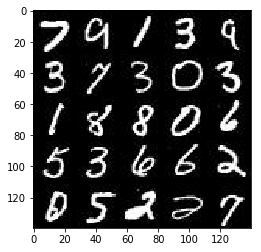

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

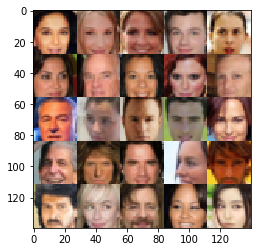

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="fake_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #first layer
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        #second layer
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        #third layer
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)

        #flatten layer 
        flat = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return(out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.01
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        #fully connected layer
        layer1 = tf.layers.dense(z, 7*7*512)
        #reshape and relu
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)

        #second layer
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)

        #logits and output
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return(d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #get the variables needed in a list
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    d_train_opr = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = d_vars)
    g_train_opr = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_vars)
    return(d_train_opr, g_train_opr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, fake_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, fake_input, data_shape[3])
    d_train, g_train = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0
       
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = batch_images * 2
                #create the batch for z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #optimizations
                _ = sess.run(d_train, feed_dict={real_input: batch_images, fake_input:batch_z, lr:learning_rate})
                _ = sess.run(g_train, feed_dict={fake_input:batch_z, lr:learning_rate})
                _ = sess.run(g_train, feed_dict={fake_input:batch_z, lr:learning_rate})
                _ = sess.run(g_train, feed_dict={fake_input:batch_z, lr:learning_rate})
                
                #print out the losses
                if step % 10 == 0:
                    discrimate_loss = sess.run(d_loss, feed_dict={real_input:batch_images, fake_input:batch_z})
                    generate_loss = sess.run(g_loss, feed_dict={fake_input:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(discrimate_loss),
                          "Generator Loss: {:.4f}".format(generate_loss))
                #this is to show the generator like the item says every 100 steps
                if step % 100 == 0:
                    show_generator_output(sess, 25, fake_input, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 0.5853
Epoch 1/2... Discriminator Loss: 2.4341... Generator Loss: 0.3418
Epoch 1/2... Discriminator Loss: 2.4499... Generator Loss: 0.2174
Epoch 1/2... Discriminator Loss: 2.4384... Generator Loss: 0.2024
Epoch 1/2... Discriminator Loss: 2.6610... Generator Loss: 0.1234
Epoch 1/2... Discriminator Loss: 2.3472... Generator Loss: 0.1955
Epoch 1/2... Discriminator Loss: 2.1651... Generator Loss: 0.4554
Epoch 1/2... Discriminator Loss: 2.0214... Generator Loss: 0.3703
Epoch 1/2... Discriminator Loss: 1.9289... Generator Loss: 0.4387
Epoch 1/2... Discriminator Loss: 1.7091... Generator Loss: 0.5725


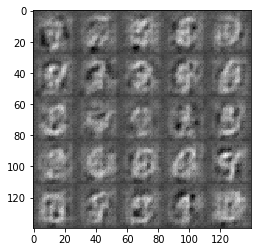

Epoch 1/2... Discriminator Loss: 2.0054... Generator Loss: 0.2269
Epoch 1/2... Discriminator Loss: 1.9265... Generator Loss: 0.2343
Epoch 1/2... Discriminator Loss: 1.8344... Generator Loss: 0.5366
Epoch 1/2... Discriminator Loss: 1.9614... Generator Loss: 0.2761
Epoch 1/2... Discriminator Loss: 1.7311... Generator Loss: 0.4904
Epoch 1/2... Discriminator Loss: 1.9111... Generator Loss: 0.6968
Epoch 1/2... Discriminator Loss: 1.8534... Generator Loss: 0.3737
Epoch 1/2... Discriminator Loss: 1.7888... Generator Loss: 0.3806
Epoch 1/2... Discriminator Loss: 1.8593... Generator Loss: 0.3335
Epoch 1/2... Discriminator Loss: 2.2236... Generator Loss: 0.1510


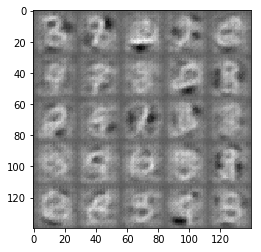

Epoch 1/2... Discriminator Loss: 1.7703... Generator Loss: 0.3544
Epoch 1/2... Discriminator Loss: 1.9101... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 1.8114... Generator Loss: 0.3365
Epoch 1/2... Discriminator Loss: 1.8853... Generator Loss: 0.4180
Epoch 1/2... Discriminator Loss: 2.0024... Generator Loss: 0.2162
Epoch 1/2... Discriminator Loss: 1.7560... Generator Loss: 0.3329
Epoch 1/2... Discriminator Loss: 1.7433... Generator Loss: 0.3167
Epoch 1/2... Discriminator Loss: 1.7509... Generator Loss: 0.3287
Epoch 1/2... Discriminator Loss: 1.7927... Generator Loss: 0.3001
Epoch 1/2... Discriminator Loss: 2.1363... Generator Loss: 0.1691


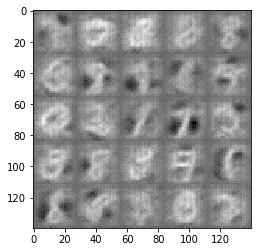

Epoch 1/2... Discriminator Loss: 1.8398... Generator Loss: 0.3590
Epoch 1/2... Discriminator Loss: 1.7321... Generator Loss: 0.5331
Epoch 1/2... Discriminator Loss: 1.7092... Generator Loss: 0.5243
Epoch 1/2... Discriminator Loss: 1.8906... Generator Loss: 0.2434
Epoch 1/2... Discriminator Loss: 1.7128... Generator Loss: 0.4471
Epoch 1/2... Discriminator Loss: 1.7815... Generator Loss: 0.3500
Epoch 1/2... Discriminator Loss: 1.7473... Generator Loss: 0.4465
Epoch 1/2... Discriminator Loss: 1.8766... Generator Loss: 0.2564
Epoch 1/2... Discriminator Loss: 1.8840... Generator Loss: 0.2299
Epoch 1/2... Discriminator Loss: 1.7467... Generator Loss: 0.3630


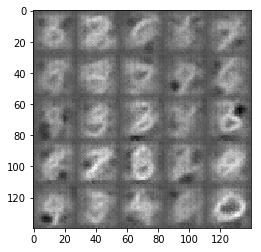

Epoch 1/2... Discriminator Loss: 1.8385... Generator Loss: 0.2805
Epoch 1/2... Discriminator Loss: 2.0045... Generator Loss: 0.1886
Epoch 1/2... Discriminator Loss: 1.8044... Generator Loss: 0.2844
Epoch 1/2... Discriminator Loss: 1.6951... Generator Loss: 0.4841
Epoch 1/2... Discriminator Loss: 1.7398... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 1.9003... Generator Loss: 0.2388
Epoch 1/2... Discriminator Loss: 1.6839... Generator Loss: 0.3744
Epoch 1/2... Discriminator Loss: 2.1761... Generator Loss: 0.1634
Epoch 2/2... Discriminator Loss: 1.7795... Generator Loss: 0.3101
Epoch 2/2... Discriminator Loss: 1.9964... Generator Loss: 0.2160


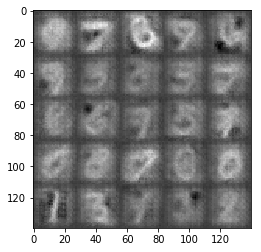

Epoch 2/2... Discriminator Loss: 1.7063... Generator Loss: 0.4882
Epoch 2/2... Discriminator Loss: 1.8355... Generator Loss: 0.2976
Epoch 2/2... Discriminator Loss: 1.7941... Generator Loss: 0.3080
Epoch 2/2... Discriminator Loss: 2.1667... Generator Loss: 0.1599
Epoch 2/2... Discriminator Loss: 1.7560... Generator Loss: 0.3612
Epoch 2/2... Discriminator Loss: 1.6828... Generator Loss: 0.3818
Epoch 2/2... Discriminator Loss: 1.7465... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.7047... Generator Loss: 0.4020
Epoch 2/2... Discriminator Loss: 1.7241... Generator Loss: 0.3376
Epoch 2/2... Discriminator Loss: 1.6559... Generator Loss: 0.4353


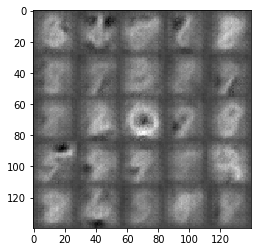

Epoch 2/2... Discriminator Loss: 1.7530... Generator Loss: 0.3919
Epoch 2/2... Discriminator Loss: 1.6874... Generator Loss: 0.3449
Epoch 2/2... Discriminator Loss: 1.8077... Generator Loss: 0.2870
Epoch 2/2... Discriminator Loss: 1.7242... Generator Loss: 0.3180
Epoch 2/2... Discriminator Loss: 1.8858... Generator Loss: 0.2526
Epoch 2/2... Discriminator Loss: 1.6539... Generator Loss: 0.5691
Epoch 2/2... Discriminator Loss: 1.7286... Generator Loss: 0.3246
Epoch 2/2... Discriminator Loss: 1.8185... Generator Loss: 0.2825
Epoch 2/2... Discriminator Loss: 1.6853... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 1.7160... Generator Loss: 0.3648


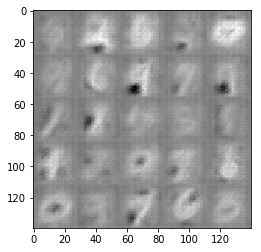

Epoch 2/2... Discriminator Loss: 1.6825... Generator Loss: 0.3502
Epoch 2/2... Discriminator Loss: 1.7534... Generator Loss: 0.3537
Epoch 2/2... Discriminator Loss: 1.6864... Generator Loss: 0.3483
Epoch 2/2... Discriminator Loss: 1.7544... Generator Loss: 0.2929
Epoch 2/2... Discriminator Loss: 1.6407... Generator Loss: 0.3974
Epoch 2/2... Discriminator Loss: 1.8313... Generator Loss: 0.2556
Epoch 2/2... Discriminator Loss: 1.7060... Generator Loss: 0.4637
Epoch 2/2... Discriminator Loss: 1.6661... Generator Loss: 0.4362
Epoch 2/2... Discriminator Loss: 1.7414... Generator Loss: 0.4538
Epoch 2/2... Discriminator Loss: 1.9242... Generator Loss: 0.2304


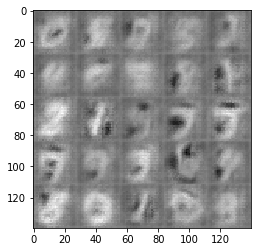

Epoch 2/2... Discriminator Loss: 1.5495... Generator Loss: 1.7818
Epoch 2/2... Discriminator Loss: 1.7471... Generator Loss: 0.3064
Epoch 2/2... Discriminator Loss: 1.7096... Generator Loss: 0.5912
Epoch 2/2... Discriminator Loss: 1.5954... Generator Loss: 0.4448
Epoch 2/2... Discriminator Loss: 1.8279... Generator Loss: 0.2744
Epoch 2/2... Discriminator Loss: 1.8699... Generator Loss: 0.2464
Epoch 2/2... Discriminator Loss: 1.8067... Generator Loss: 0.4345
Epoch 2/2... Discriminator Loss: 1.5918... Generator Loss: 0.4047
Epoch 2/2... Discriminator Loss: 1.8490... Generator Loss: 0.2765
Epoch 2/2... Discriminator Loss: 1.6639... Generator Loss: 0.3312


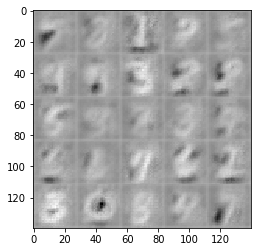

Epoch 2/2... Discriminator Loss: 1.8843... Generator Loss: 0.2351
Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.5282
Epoch 2/2... Discriminator Loss: 1.7008... Generator Loss: 0.3436
Epoch 2/2... Discriminator Loss: 1.5966... Generator Loss: 0.4306
Epoch 2/2... Discriminator Loss: 1.5851... Generator Loss: 0.5318
Epoch 2/2... Discriminator Loss: 1.6776... Generator Loss: 0.4744


In [17]:
batch_size = 125
z_dim = 150
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.0935... Generator Loss: 0.0899
Epoch 1/1... Discriminator Loss: 3.7062... Generator Loss: 0.1094
Epoch 1/1... Discriminator Loss: 2.5903... Generator Loss: 0.2087
Epoch 1/1... Discriminator Loss: 2.1746... Generator Loss: 0.2788
Epoch 1/1... Discriminator Loss: 2.7898... Generator Loss: 0.2708
Epoch 1/1... Discriminator Loss: 2.3698... Generator Loss: 0.2849
Epoch 1/1... Discriminator Loss: 2.3653... Generator Loss: 0.2700
Epoch 1/1... Discriminator Loss: 1.9403... Generator Loss: 0.4727
Epoch 1/1... Discriminator Loss: 1.9672... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 1.8856... Generator Loss: 0.4486


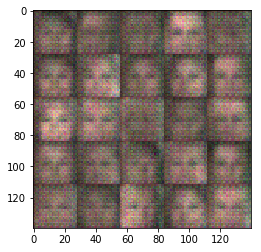

Epoch 1/1... Discriminator Loss: 1.8519... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.8839... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.6672... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.7882... Generator Loss: 0.4535
Epoch 1/1... Discriminator Loss: 1.7002... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.7260... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.8379... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.6829... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.8035... Generator Loss: 0.4516


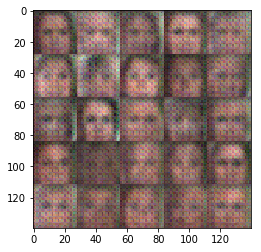

Epoch 1/1... Discriminator Loss: 1.7449... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.8069... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.7491... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.6512... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.6393... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.6269


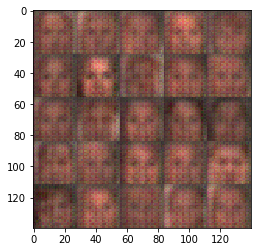

Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.6254... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.6183... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.6699... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.6442... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.5961


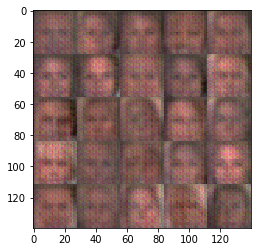

Epoch 1/1... Discriminator Loss: 1.6313... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 0.5916


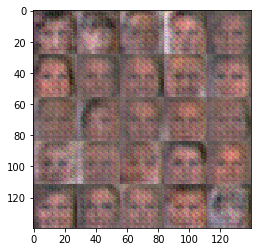

Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.5936


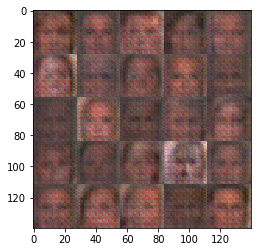

Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6533


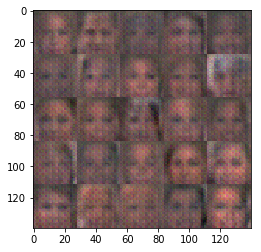

Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6503


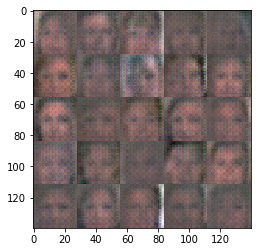

Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.6169


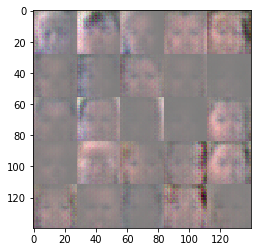

Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6269


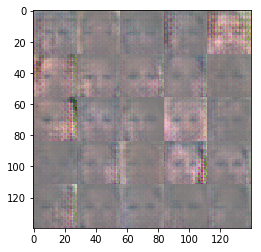

Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6289


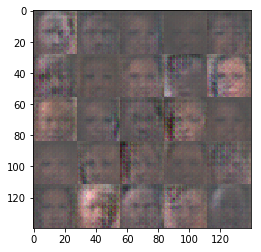

Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6021


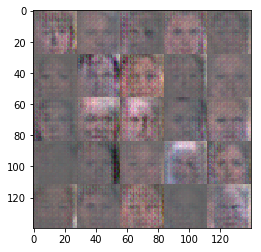

Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6370


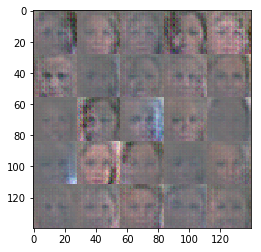

Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6560


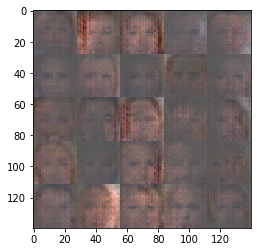

Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6795


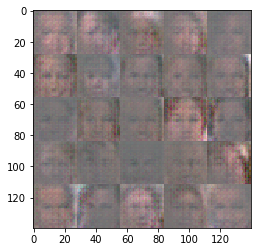

Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6354


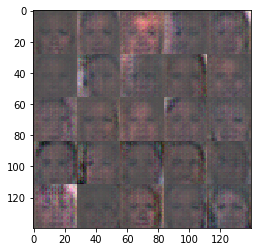

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6205


In [20]:
batch_size = 125
z_dim = 150
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.